<h2> Data & Motivation </h2>
The purpose of this document is to use XGBoost & Shapley values to get some insight into a dataset. I'm going to use some simple libraries to come to cool conclusions on some OKCupid data. I've been interested in using machine learning to understand more about dating habits for awhile. Fortunately, there is a dataset on OKCupid collected by Kirkegaard and Bjerrekaer (https://figshare.com/articles/dataset/OKCupid_Datasets/14987388). It features 68371 records with information collected on how they've answered questions, some descriptive information, and some innate scores that OKCupid gives each profile. There's already been plenty of work done regarding this dataset, so I want to focus on something more niche. I want to understand more about how well political questions can predict the age of users. Afterward, I'll look to extract some key insights about how the inputs (political question answers) influence the target (user age). 


<h2> EDA </h2>
To start, the data is present in two files; one file for question indexes and one with the indexed data. We can load the data in and start doing some EDA. We'll want to examine what the data looks like.

In [1]:
# Imports first as usual
import pandas as pd
from sklearn.cluster import Birch
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import r2_score, mean_squared_error
import xgboost as xgb
import optuna
import shap
import matplotlib
from IPython.display import display
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")
optuna.logging.set_verbosity(optuna.logging.WARNING)

data = pd.read_parquet("C:\\Users\\mccal\\Documents\\portfolio\\data\\parsed_data_public.parquet")
questions = pd.read_csv("C:\\Users\\mccal\\Documents\\portfolio\\data\\question_data.csv", delimiter=";", index_col=0)
data.set_index("Unnamed: 0", inplace=True)
display(data.head())
display(data.shape)
display(questions.head())
display(questions.shape)

c:\Users\mccal\.pyenv\pyenv-win\versions\3.10.6\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


,q2,q11,q12,q13,q14,q16,q17,q18,q20,q22,...,q86615,q86699,q363047,CA,gender_orientation,gender,race,gender2,gender2_num,CA_items
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
1,None,Horrified,None,None,None,None,No,None,None,None,...,None,None,None,0.763080,Hetero_female,Woman,White,Woman,0.0,4
2,None,None,None,None,None,None,None,None,None,None,...,None,None,None,NaN,Hetero_male,Man,None,Man,1.0,0
3,None,None,None,No,No,None,No,None,None,None,...,None,None,None,0.661309,Hetero_female,Woman,None,Woman,0.0,7
4,None,None,None,None,None,None,None,None,None,None,...,None,None,None,NaN,Hetero_female,Woman,White,Woman,0.0,0
5,None,None,None,None,None,None,None,None,None,None,...,None,None,None,0.875424,Bisexual_female,Woman,None,Woman,0.0,3


(68371, 2625)

,text,option_1,option_2,option_3,option_4,N,Type,Order,Keywords
q2,Breast implants?,more cool than pathetic,more pathetic than cool,NaN,NaN,24839,N,NaN,sex/intimacy; preference; opinion
q11,How does the idea of being slapped hard in the...,Horrified,Aroused,Nostalgic,Indifferent,28860,N,NaN,sex/intimacy
q12,Divide your age by 2. Have you had sex with a...,Yes,No,NaN,NaN,22496,O,NaN,sex/intimacy
q13,Is a girl who's slept with 100 guys a bad person?,Yes,No,NaN,NaN,32581,O,NaN,sex/intimacy
q14,Is a guy who's slept with 100 girls a bad person?,Yes,No,NaN,NaN,31127,O,NaN,sex/intimacy


(2620, 9)

There are quite a lot of questions - 2620! Let's get some more information on what the questions look like. There are many questions that slot into each of the categories.

In [2]:
keywords = set(questions.Keywords)
keywords.remove(np.NaN)
print(keywords)

{'politics; sex/intimacy; preference', 'preference', 'sex/intimacy; opinion', 'opinion; technology', 'cognitive', 'politics; sex/intimacy; descriptive', 'preference; descriptive', 'descriptive; preference; opinion', 'politics; descriptive; preference', 'politics', 'preference; cognitive', 'preference; technology', 'descriptive', 'sex/intimacy; preference; descriptive', 'descriptive; BDSM', 'religion/superstition; preference', 'sex/intimacy; descriptive; BDSM', 'religion/superstition', 'preference; descriptive; technology', 'sex/intimacy; preference; opinion', 'politics; opinion; cognitive', 'politics; opinion; sex/intimacy', 'politics; preference; opinion; sex/intimacy', 'preference; descriptive; cognitive', 'politics; sex/intimacy; religion/superstition; opinion', 'politics; opinion; technology', 'preference; opinion', 'opinion; descriptive', 'religion/superstition; descriptive; preference', 'opinion; cognitive', 'opinion', 'politics; sex/intimacy; religion/superstition ', 'politics; 

There are some themes amongst the questions. As stated above, I'm most interested in how political questions influence some of the descriptive traits that OKCupid has gathered. However, there are plenty of other very interesting categories to explore some other time. To reduce the number of features we're fitting with, I'll only select the most answered political questions. I'm only picking so many because we'll need to one hot encode these, which can cause far too many features while fitting.

<class 'pandas.core.frame.DataFrame'>
Int64Index: 68371 entries, 1 to 68371
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   q179268  54202 non-null  object
 1   q403     52369 non-null  object
 2   q175     45720 non-null  object
 3   q212813  45107 non-null  object
 4   q612     44907 non-null  object
 5   q838     44461 non-null  object
 6   q27921   42307 non-null  object
 7   q20519   40256 non-null  object
 8   q85835   38702 non-null  object
 9   q37708   37661 non-null  object
dtypes: object(10)
memory usage: 5.7+ MB


None

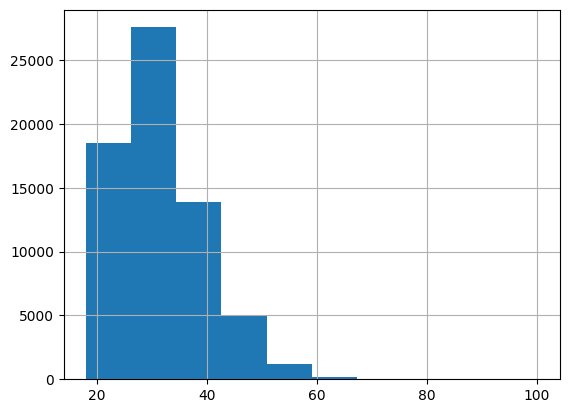

In [3]:
politics = [x for x in keywords if x.startswith("politics")]
question_subset = questions[questions["Keywords"].isin(politics)]
top_politics = question_subset.sort_values("N", ascending=False).iloc[0:10]
data["d_age"].hist()
display(data[top_politics.index].info())

The descriptive properties are denoted with "d_". For kicks, let's look at the other descriptive features available in this dataset.

In [4]:
descriptives = [column for column in data.columns if column.startswith("d_")]
print(descriptives)
data["d_age"].describe()

['d_astrology_seriosity', 'd_education_phase', 'd_gender', 'd_income', 'd_religion_type', 'd_drugs', 'd_smokes', 'd_astrology_sign', 'd_country', 'd_drinks', 'd_age', 'd_ethnicity', 'd_offspring_current', 'd_bodytype', 'd_job', 'd_orientation', 'd_languages', 'd_relationship', 'd_offspring_desires', 'd_education_type', 'd_religion_seriosity']


count    66365.000000
mean        31.657334
std          7.801813
min         18.000000
25%         26.000000
50%         30.000000
75%         36.000000
max        100.000000
Name: d_age, dtype: float64

<h2> Preprocessing </h2>

It's now time to preprocess our data. Let's start by specifying our target and dropping rows with missing data. Since we're dropping rows, we should just double check that we've still got a sufficient amount of rows to fit a model. We can also specify our modelling features to get our modelling data.

In [5]:
features = top_politics.index.tolist()
target = ["d_age"]
subset_data = data[features + target]
subset_data = subset_data.dropna()
print("Data shape: %s" % str(subset_data.shape))

Data shape: (19542, 11)


We're left with plenty of observations that have completed all of our training questions, which should be plenty for our model. The features are all nominal or ordinal, which means we'll need to encode them prior to fitting. I'll use sklearn's one hot encoder. By specifying that we'll drop the first observation category, it will make the Shapley values later more interpretable.

In [6]:
ohe = OneHotEncoder(sparse=False, drop="first")
inputs = ohe.fit_transform(subset_data[features])

<h2> Modelling & Parameter Selection </h2>

Now that we've got our data processed, we can split the data into a test/train set and find a few success metrics to judge the fit. I personally prefer MSE to judge testing data, but I'll include a few others too. Adjusted-r-squared on the train set is also fairly important, as we'll want a good view into how well the model fits the training data.

In [7]:
xtrain, xtest, ytrain, ytest = train_test_split(
    inputs, subset_data[target], random_state=1
)


xgb_regressor = xgb.XGBRegressor(random_state=1)
xgb_regressor.fit(xtrain, ytrain)
predictions = xgb_regressor.predict(xtest)
predictions - ytest.values
mse = mean_squared_error(ytest.values, predictions)
r2 = r2_score(ytrain.values, xgb_regressor.predict(xtrain))
adj_r2 = 1 - (1 - r2) * (xtrain.shape[0] - 1) / (xtrain.shape[0] - xtrain.shape[1] - 1)
absolute_average_error = np.mean(abs(ytest.values - predictions))
paae = absolute_average_error / np.mean(ytest.values)

print("mse: %f" % mse)
print("adj_r2: %f" % adj_r2)
print("percent absolute average error: %f" % paae)

mse: 63.426959
adj_r2: 0.130507
percent absolute average error: 0.187786


These results are not as exciting as I'd have hoped! The percent absolute average error is rather high. The MSE is also very high for a number that's bounded between 18 and 100, especially since 50% of the users are between 26 and 36. To remedy this, let's create a hyper parameter optimiser to tune some of the XGBoost parameters. We'll split out our data into a set we can tune, then get our final fit metrics with the rest.

My library of choice right now for optimisation is Optuna (https://optuna.org/). It's an incredibly accessible library with some pretty cool optimisation methods. We will subset the data into an optimisation and modelling set so that we can get a good idea of the parameters' true performance. To use Optuna, we'll need to define a training function that we can optimise the loss metric of. Considering I like MSE, we'll be using MSE as our modelling objective to minimise. Optuna allows multi-objective optimisation, so I can also optimise toward a better adjusted-r-squared. The combination of MSE and adjusted-r-squared means that we can pick a good point on the bias/variance tradeoff curve.

We'll pick a optimisation/holdout split of 3/4's optimisation and 1/4 holdout. Our optimiser will train on the 3/4's of data by using a train/test split. Once we've idenfitied the best parameters, we'll retrain the model with all of the optimisation set (training and test), then test the trained model on our holdout set. Optuna picks a list of "best trials" when doing multi-objective optimisation, so we'll need to work out for ourselves which trial is truly the best.

In [8]:
training_split = 0.75
hpo_data = subset_data.iloc[: int(training_split * subset_data.shape[0])]
modelling_data = subset_data.iloc[int(training_split * subset_data.shape[0]) :]

hpo_inputs = ohe.fit_transform(hpo_data[features])
hpox_train, hpox_test, hpo_ytrain, hpo_ytest = train_test_split(
    hpo_inputs, hpo_data[target], random_state=1
)


def objective(trial):

    # Invoke suggest methods of a Trial object to generate hyperparameters.
    eta = trial.suggest_float("eta", 0.0001, 0.1)
    gamma = trial.suggest_float("gamma", 0, 1000)
    max_depth = trial.suggest_int("max_depth", 1, 10)
    xgb_regressor = xgb.XGBRegressor(
        eta=eta, gamma=gamma, max_depth=max_depth, random_state=1
    )
    xgb_regressor.fit(hpox_train, hpo_ytrain)
    predictions = xgb_regressor.predict(hpox_test)
    mse = mean_squared_error(hpo_ytest.values, predictions)

    r2 = r2_score(hpo_ytrain, xgb_regressor.predict(hpox_train))
    adj_r2 = 1 - (1 - r2) * (hpox_train.shape[0] - 1) / (
        hpox_train.shape[0] - hpox_train.shape[1] - 1
    )
    trial.set_user_attr(key="best_booster", value=xgb_regressor)
    return mse, adj_r2


def callback(study, trial):
    if study.best_trials[0].number == trial.number:
        study.set_user_attr(key="best_booster", value=trial.user_attrs["best_booster"])


study = optuna.create_study(directions=["minimize", "maximize"])  # Create a new study.
study.optimize(
    objective,
    n_trials=700,
    callbacks=[callback],
    timeout=1200,
)  # Invoke optimization of the objective function.

In [9]:
best_mse, best_adj_r2 = study.best_trials[0].values
improvement = abs(best_mse - mse) / mse

print("First trial MSE %f" % best_mse)
print("MSE improvement %f" % improvement)
print("First trial adj_r2 %f" % best_adj_r2)

First trial MSE 59.647349
MSE improvement 0.059590
First trial adj_r2 0.104388


If we investigate all of the best trials, it actually looks like there's an inverse relationship between smaller MSE and higher adjusted r-squared. When plotting the values, it's a logarithmic relationship! Since it looks like a saturation curve and we'd like a reasonable adjusted r-squared and MSE, we should pick something in the middle. I'll use the second derivative of MSE by adjusted-r-squared and select the ordered parameter set the closest to zero. We'll also retrain the model with the best parameters using all of our training data.

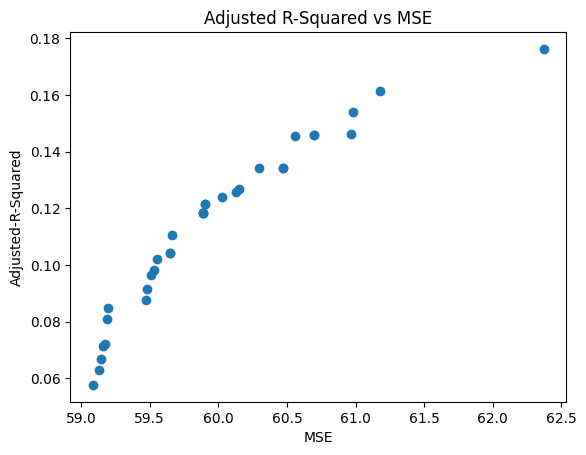

In [10]:
plt.scatter(
    [x.values[0] for x in study.best_trials], [x.values[1] for x in study.best_trials]
)
plt.title("Adjusted R-Squared vs MSE")
plt.xlabel("MSE")
plt.ylabel("Adjusted-R-Squared")
plt.show()

In [11]:
second_derivative = np.gradient(
    [x.values[0] for x in study.best_trials], [x.values[1] for x in study.best_trials]
)
minimum_derivative = min(abs(second_derivative))
minimum_index = np.where(abs(second_derivative) == minimum_derivative)
sorted_params = [x.values for x in study.best_trials]
sorted_params.sort()
best_params = study.best_trials[minimum_index[0].tolist()[0]].params
xgb_regressor = xgb.XGBRegressor(**best_params, random_state=1)
xgb_regressor.fit(hpo_inputs, hpo_data[target])

r2 = r2_score(hpo_data[target], xgb_regressor.predict(hpo_inputs))
adj_r2 = 1 - (1 - r2) * (hpo_inputs.shape[0] - 1) / (
    hpo_inputs.shape[0] - hpo_inputs.shape[1] - 1
)
print("Retrained adj_r2 %f" % adj_r2)

Retrained adj_r2 0.056632


We're finally ready to try our new parameters on the holdout set! Considering adjusted r-squared is for training data, we'll just look at the regular r-squared on the holdout set. However, we're most interested in the MSE, as this describes how well our model can predict age from political questions.

Optimal MSE: 55.874739
Final MSE improvement: 0.119070
Final r2 score: 0.020390


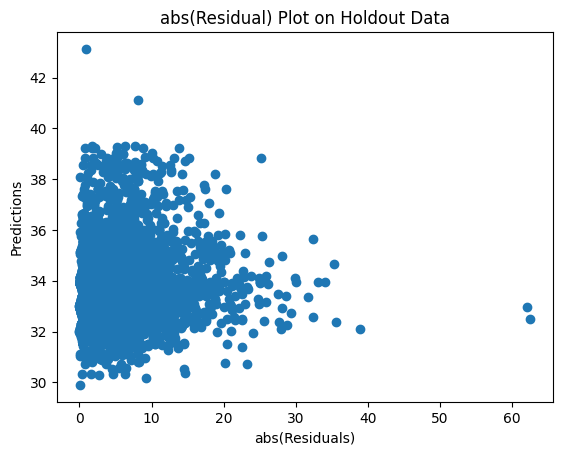

In [12]:
best_model = xgb_regressor
modelling_inputs = ohe.transform(modelling_data[features])


predictions = best_model.predict(modelling_inputs)
predictions - modelling_data[target].values
final_r2 = r2_score(modelling_data[target].values, best_model.predict(modelling_inputs))
mse_optim = mean_squared_error(modelling_data[target].values, predictions)
final_mse = abs(mse - mse_optim) / mse
print("Optimal MSE: %f" % mse_optim)
print("Final MSE improvement: %f" % final_mse)
print("Final r2 score: %f" % final_r2)
plt.scatter(abs(modelling_data[target].iloc[:, 0].values - predictions), predictions)
plt.title("abs(Residual) Plot on Holdout Data")
plt.xlabel("abs(Residuals)")
plt.ylabel("Predictions")
plt.show()

Our MSE on the test set is fantastic! Unfortunately the r-squared leaves a lot to be desired, but it's not shocking as this is the test set. This means our tuned parameters are much more effective at predicting the correct answers, but the features explain less of the target variance. The absolute of residuals plot doesn't look too bad either - there's a strong concentration where abs(Residuals) is zero, which is good.

<h2> Shapley Values </h2>

Now that we've got a model that's reasonably good at predicting, we can also use our holdout dataset to understand which of our features are most influential in deciding user ages. We'll use the shap library (https://shap.readthedocs.io/en/latest/), which utilises Shapley values from game theory.

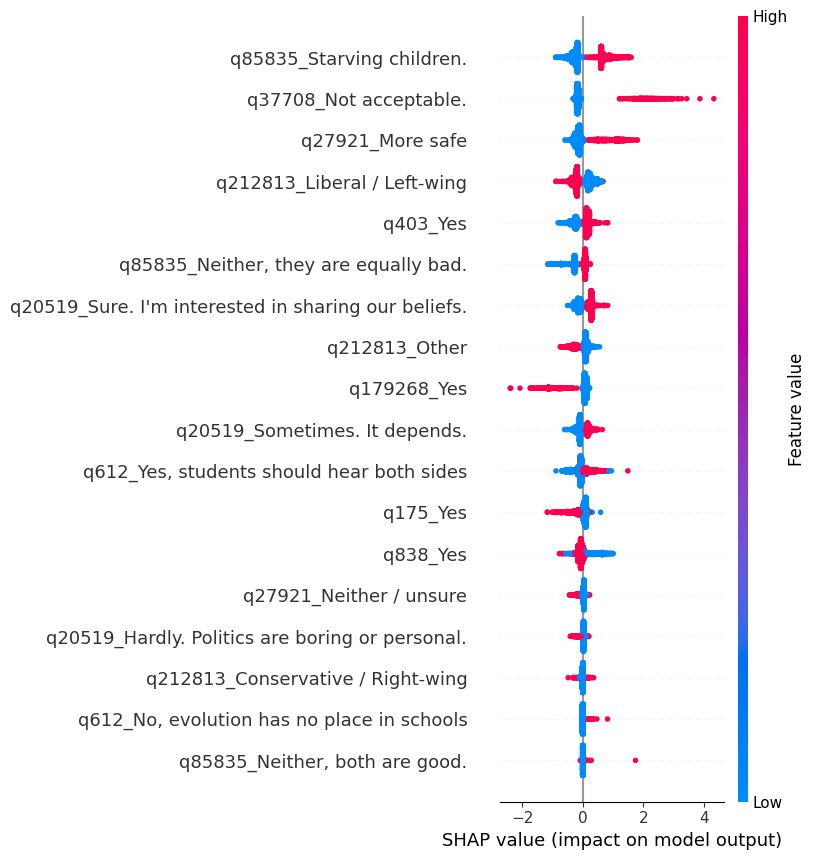

In [13]:
feature_names = modelling_data.columns
explainer = shap.TreeExplainer(xgb_regressor)
shap_values = explainer.shap_values(hpox_test)
shap.summary_plot(shap_values, hpox_test, feature_names=ohe.get_feature_names_out())

<h2> Conclusions </h2>

We can now analyse the most influential features for predicting user age. The force plots that the shap library give an ordered list of the most influential features. Let's get a look at which questions we've actually selected and see if we can't pull some interesting conclusions out..

In [14]:
questions.loc[top_politics.index]

,text,option_1,option_2,option_3,option_4,N,Type,Order,Keywords
q179268,Are you either vegetarian or vegan?,Yes,No,NaN,NaN,54202,O,NaN,politics; descriptive
q403,Do you enjoy discussing politics?,Yes,No,NaN,NaN,52369,O,NaN,politics; preference; descriptive
q175,Should burning your country's flag be illegal?,Yes,No,NaN,NaN,45720,O,NaN,politics
q212813,Which best describes your political beliefs?,Liberal / Left-wing,Centrist,Conservative / Right-wing,Other,45107,M,[4],politics; descriptive
q612,Should evolution and creationism be taught sid...,"Yes, students should hear both sides","No, creationism has no place in schools","No, evolution has no place in schools",NaN,44907,O,"2, 1, 3",politics; religion/superstition
q838,"For you personally, is abortion an option in c...",Yes,No,NaN,NaN,44461,O,NaN,politics; religion/superstition; opinion
q27921,Do you believe your country would be more or l...,More safe,Less safe,Neither / unsure,NaN,42307,O,"2, 3, 1",politics; opinion
q20519,In a relationship I like to discuss politics w...,All the time!,Sure. I'm interested in sharing our beliefs.,Sometimes. It depends.,Hardly. Politics are boring or personal.,40256,O,NaN,politics; preference
q85835,Which is worse: starving children or abused an...,Starving children.,Abused animals.,"Neither, both are good.","Neither, they are equally bad.",38702,O,"3, (1, 2), 4",politics; opinion
q37708,The idea of gay and lesbian couples having chi...,Acceptable.,Not acceptable.,NaN,NaN,37661,O,NaN,politics; religion/superstition; opinion


If we combine the questions with the Shapley value summaries, then we can get some interesting insights on the data! Interestingly enough, it looks like answers associated with political "sides" (right/left leaning) are more related to predicting age, such as actively identifying as conservative or liberal, gay adoption, and abortion. This matches the prevailing trends where older people tend to have more conservative values. For example, if someone answers that they think gay and lesbian people adopting is not acceptable, they're more likely to be older. What's especially interesting is that not answering "liberal" to the political affiliation question has a stronger impact on skewing a prediction to be older than if they'd answered "conservative"!